## Public Construction
The below code builds and tests a linear regression based time series model.  This is the simplier (linear) of the two models we learned about in class this week.  This model is $D\left(q \right) = L + T \left(q \right) + S \left(q \right) + \epsilon \left( q \right)$. Where $D$ is the forcasted value, $L$ and $T$ are the linear regression intercept and slope respectively, and $S$ is the seasonal impact.   In this case we use a least squares regression to determine the Y-interecept and the slope of the $trend$ line.  I then determined that a 12 month lag best fits the seasonal model, so we take the average for each period (i.e. month) and use this to build the seasonal aspect of the model. This is done by finding the difference between the linear model and the actual data.  We call this R1. Finally, we compare the model results to the actual data to determine how well the model fits.  Our final model has a R squared of 0.7913, so it looks pretty good.

In [1]:
# import the packages needed for regression, plotting, and working with dates and download the data.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
%matplotlib inline
dfcon = pd.read_csv("ConstructionTimeSeriesDataV2.csv")#download data
dfcon.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


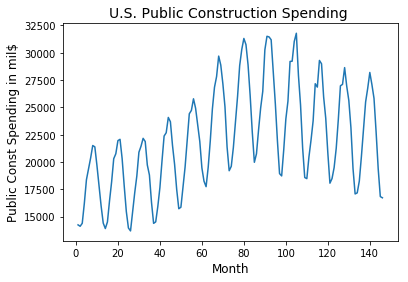

In [2]:
fig,ax=plt.subplots()
ax.plot(dfcon["Month"],dfcon["Public Construction"])
plt.xlabel('Month', fontsize=12)
plt.ylabel('Public Const Spending in mil$',fontsize=12)
plt.title('U.S. Public Construction Spending ',fontsize=14)
plt.show()

### Building the regression
Although the trend for this data series seems like a quadradic regression might fit it better, a linear still looks pretty good and I would argue we cannot tell the trend past 140 months, so I am going with a least squares linear for the trend model. Based off the very low $p$ value and the $R^2$ I feel pretty good about using a linear regression model for the trend. Hoping that I can explain the rest of the variation with the time series work. 

In [3]:
#Find the trend portion of the model - which is the linear regression.
slope, intercept, r_value, p_value,std_err=stats.linregress(dfcon.index,dfcon["Public Construction"])
print(slope, intercept, r_value, p_value,std_err)

52.00857586303299 18327.939893765724 0.4661807818302608 3.0283490070076672e-09 8.22489218175051


Slope = 52.00857586303299 Interecept= 18327.939893765724 $R^2$=0.4661807818302608 $p$= 3.0283490070076672e-09 std er=8.22489218175051

In [4]:
#Lets look at the regression model and see how the model behaves when the trend is accounted for. (ie look at the seasonality)

def create_regression_col(row,intercept,slope):
    return (float(intercept)+float(row['Month']*slope))#substituting the regressor variable into the model to make a column

dfcon['regress']=dfcon.apply(create_regression_col,args=(intercept,slope), axis="columns")#put model in data frame
#R1 shows the seasonality by itself
dfcon['R1']=dfcon['Public Construction']-dfcon['regress']#look at the difference between the regression model and data
dfcon.head()


,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1
0,1,Jan-02,59516,45273,14243,18379.948470,-4136.948470
1,2,Feb-02,58588,44475,14113,18431.957045,-4318.957045
2,3,Mar-02,63782,49396,14386,18483.965621,-4097.965621
3,4,Apr-02,69504,53283,16221,18535.974197,-2314.974197
4,5,May-02,73384,55009,18375,18587.982773,-212.982773


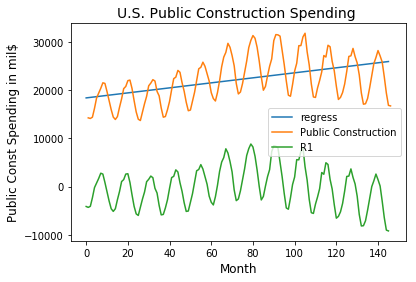

In [5]:
#I just want to see how the initial models line up with the data
plt.plot(dfcon.index,dfcon.regress)
plt.plot(dfcon["Month"],dfcon["Public Construction"], label="Public Construction")#shows how well the regression model fits visually.
plt.plot(dfcon.index,dfcon.R1, label="R1")#delta between regression and data - shows seasonality
plt.xlabel('Month', fontsize=12)
plt.ylabel('Public Const Spending in mil$',fontsize=12)
plt.title('U.S. Public Construction Spending ',fontsize=14)
plt.legend(loc="right")

### Seasonality 
Determining the level of correlation with previous time periods (autocorrelation) we can account for the seasonality.

In [6]:
for i in range(int(len(dfcon.index)/2)):
    print('autocorrelation, lag=',i,':',dfcon.R1.autocorr(lag=i) )#largest correlation is best lag for the model

autocorrelation, lag= 0 : 1.0
autocorrelation, lag= 1 : 0.8856280681661076
autocorrelation, lag= 2 : 0.6013224790427005
autocorrelation, lag= 3 : 0.21586708487588246
autocorrelation, lag= 4 : -0.16610636997182948
autocorrelation, lag= 5 : -0.42768100297253514
autocorrelation, lag= 6 : -0.5179874711984136
autocorrelation, lag= 7 : -0.4183206340816582
autocorrelation, lag= 8 : -0.15136655336477844
autocorrelation, lag= 9 : 0.21954961123223027
autocorrelation, lag= 10 : 0.5790216579473371
autocorrelation, lag= 11 : 0.8451120068400938
autocorrelation, lag= 12 : 0.9457610635882284
autocorrelation, lag= 13 : 0.8276421035386302
autocorrelation, lag= 14 : 0.5396014613105624
autocorrelation, lag= 15 : 0.14119515861605372
autocorrelation, lag= 16 : -0.24754432310853827
autocorrelation, lag= 17 : -0.5174466437147164
autocorrelation, lag= 18 : -0.6153653553854782
autocorrelation, lag= 19 : -0.519201082967975
autocorrelation, lag= 20 : -0.2550096270492797
autocorrelation, lag= 21 : 0.11488543284738

12 month cycle has the best autocorrelation. (.94) This makes sense - the data cycles every year (so Januarys are similiar....) Below we look at the graph of each cycle and see the groups.  Then we will find the average.

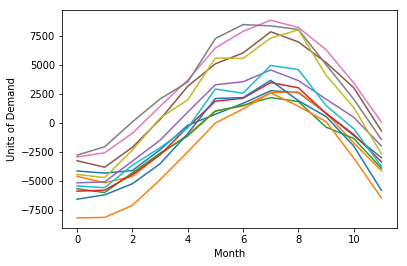

In [7]:
#here we make a new data frame that looks at the cyclic data by month.  I know what is happening.  
#we are finding the average value for the difference in the seasonality for each month - this is our Seasonality factor
#in the model y=Intercept+Trend+Season+error
dfconMonth=pd.DataFrame() 
cycleLen=12
for i in range(int(len(dfcon.index)/cycleLen)):
               newData=pd.DataFrame({i:dfcon['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})#This took me a while to understand
        #but now I see that we are just looking at the values for each month
               newData.index=range(0,len(newData))
               dfconMonth=pd.concat([dfconMonth,newData],axis=1)
dfconMonth.iloc[1:20]
fig,ax=plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.plot(dfconMonth)


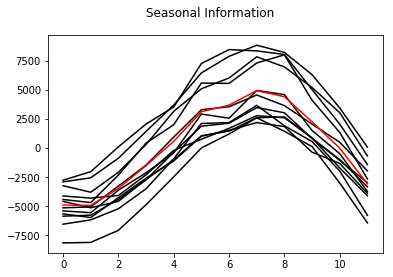

In [8]:
avg=[]
for i in range(len(dfconMonth.index)):
    avg.append(dfconMonth.iloc[i].mean())#find the average change for each month across all seasons. This average is what we 
    #will use to offset the fact we are in a certain month
dfconMonth=pd.concat([dfconMonth,pd.DataFrame({'avg':avg})],axis=1)
#print(dfMonth)

fig,ax=plt.subplots()
fig.suptitle('Seasonal Information')
c=180
for col in dfconMonth.columns.values:
    if col=='avg':
        ax.plot(dfconMonth[col],c='r')
    else:
        ax.plot(dfconMonth[col],c='k')

### Bringing it all together.
Now that we have determined the seasonal effect for months 1-12, we add a column to the data frame called "S" which is the average seasonal impact for each month.  We then use R2 which is the difference between the model without trend impact and S to determine an error.  Additionally, we add a column called composite which brings the entire model together. As can be seen in the below plot, the models appear to account for the variablilty in the data.  

In [9]:
dfcon['S']=np.NaN #create empty column for the Seasonality factor
dfcon['R2']=np.NaN 
dfcon['Composite']=np.NaN #column for the completed model
dfcon['errorPerc']=np.NaN #good way to look at the error
S=dfconMonth['avg'].tolist() 
for i in dfcon.index:
    dfcon.loc[i,'S']=S[i%cycleLen]#putting the seasonal model in the data frame
    dfcon.loc[i,'R2']=dfcon.loc[i,'R1']-dfcon.loc[i,'S']
    dfcon.loc[i,'Composite']=dfcon.loc[i,'regress']+dfcon.loc[i,'S'] #the actual model
    dfcon.loc[i,'errorPerc'] = 100*dfcon.loc[i,'R2']/dfcon.loc[i,'Public Construction'] #a way to look at the accuracy of the model
dfcon

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1,S,R2,Composite,errorPerc
0,1,Jan-02,59516,45273,14243,18379.948470,-4136.948470,-4915.264477,778.316007,13464.683993,5.464551
1,2,Feb-02,58588,44475,14113,18431.957045,-4318.957045,-4945.773052,626.816007,13486.183993,4.441409
2,3,Mar-02,63782,49396,14386,18483.965621,-4097.965621,-3493.781628,-604.183993,14990.183993,-4.199805
3,4,Apr-02,69504,53283,16221,18535.974197,-2314.974197,-1522.706871,-792.267326,17013.267326,-4.884208
4,5,May-02,73384,55009,18375,18587.982773,-212.982773,554.701220,-767.683993,19142.683993,-4.177872
5,6,Jun-02,77182,57801,19381,18639.991349,741.008651,3103.942644,-2362.933993,21743.933993,-12.192013
6,7,Jul-02,78863,58494,20369,18691.999925,1677.000075,3670.017402,-1993.017326,22362.017326,-9.784561
7,8,Aug-02,79460,57953,21507,18744.008501,2762.991499,4915.675492,-2152.683993,23659.683993,-10.009225
8,9,Sep-02,76542,55157,21385,18796.017077,2588.982923,4400.250250,-1811.267326,23196.267326,-8.469803
9,10,Oct-02,75710,56023,19687,18848.025652,838.974348,2238.991674,-1400.017326,21087.017326,-7.111380


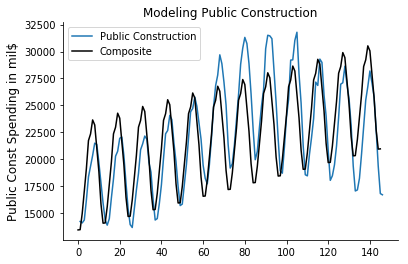

In [10]:
fig,ax=plt.subplots()
ax.plot(dfcon["Month"],dfcon["Public Construction"])
plt.ylabel('Public Const Spending in mil$',fontsize=12)
ax.plot(dfcon['Composite'], c='k')
plt.title("Modeling Public Construction")
plt.ylabel('Public Const Spending in mil$',fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg=ax.legend()


This graph looks pretty good.  I feel like we have captured the seasonality and the trend! However, we have developed the cumulative square error to really delve into the amount of difference there is between the model and the data.

### How is the fit
I would argue that the cumulative squared error is not too big.  Once you take the square root, you can see it in the appropriate scale.  25k and change really is not that substantial given the scale and size of the data.  We are also seeing error percentages around 10% which is not horrible given this quick model.  Finally, I know $R^2$ is not the greatest tool for evaluating a model. However an $R^2$ of 0.79 does support the low error. 

In [15]:
dfcon['R2Public']=dfcon['Public Construction']-dfcon['Composite'] #As stated in assignment - delta between real data and model
dfcon['R2ErrorPublic']=dfcon['R2Public']/dfcon['Public Construction'] #error  relative to (divided by) the original data series.
dfcon['squaredError']=dfcon['R2Public']*dfcon['R2Public'] #squared error
dfcon['cumulativeSquaredError'] = dfcon['squaredError'].cumsum()#cumulative squared error(iloc.[1:3])
print('The Cumulative Square error is ', dfcon.iloc[-1,14] )
print('the Cum. Square error seems big, but the square root is ',(dfcon.iloc[-1,14])**.5)
dfcon.iloc[1:10,[0,8,9,10,11,12,13,14]]


The Cumulative Square error is  659867060.3752402
the Cum. Square error seems big, but the square root is  25687.87769309174


,Month,R2,Composite,errorPerc,R2Public,R2ErrorPublic,squaredError,cumulativeSquaredError
1,2,626.816007,13486.183993,4.441409,626.816007,0.044414,3.928983e+05,9.986741e+05
2,3,-604.183993,14990.183993,-4.199805,-604.183993,-0.041998,3.650383e+05,1.363712e+06
3,4,-792.267326,17013.267326,-4.884208,-792.267326,-0.048842,6.276875e+05,1.991400e+06
4,5,-767.683993,19142.683993,-4.177872,-767.683993,-0.041779,5.893387e+05,2.580739e+06
5,6,-2362.933993,21743.933993,-12.192013,-2362.933993,-0.121920,5.583457e+06,8.164196e+06
6,7,-1993.017326,22362.017326,-9.784561,-1993.017326,-0.097846,3.972118e+06,1.213631e+07
7,8,-2152.683993,23659.683993,-10.009225,-2152.683993,-0.100092,4.634048e+06,1.677036e+07
8,9,-1811.267326,23196.267326,-8.469803,-1811.267326,-0.084698,3.280689e+06,2.005105e+07
9,10,-1400.017326,21087.017326,-7.111380,-1400.017326,-0.071114,1.960049e+06,2.201110e+07


Just for fun I used $\frac{SSR}{SST}$ to determine the $R^2$ of the new model.

In [13]:

ssrCol=[]
ssrCol=(dfcon['Composite']-dfcon['Public Construction'].mean())*(dfcon['Composite']-dfcon['Public Construction'].mean())
ssr = ssrCol.sum()
sse=dfcon['squaredError'].sum()
sst=sse+ssr
rsquared=ssr/sst
print(rsquared)

0.7913964607138019
